In [2]:
import os
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ============================================
# 0. 설정
# ============================================

DATA_ROOT = r"C:\Users\kjhye\Dropbox\Python\Sea Surface Tem(SSS)\XBT\XBT\data_RDS"  
JLD2_PATH = os.path.join(DATA_ROOT, "data_tnsr.jld2")
TIME_CSV  = os.path.join(DATA_ROOT, "data_GLBy0.08_expt_93.0.csv")
LAT_CSV   = os.path.join(DATA_ROOT, "lat.csv")
LON_CSV   = os.path.join(DATA_ROOT, "lon.csv")

# 대시보드에서처럼 1 / 7 / 30일 RMSE 계산
HORIZON_DAYS = [1, 7, 30]
MAX_H = max(HORIZON_DAYS)

# --- ARIMA 하이퍼파라미터  ---
ARIMA_CONFIGS = [
    {"order": (2, 1, 3)},     
   
]

# --- history 길이(input) 후보 (대시보드 표의 input 열) ---
INPUT_LIST = [30]             # 30일 history 

# t0 샘플 개수 (너무 많으면 오래 걸림)
N_T0_SAMPLES = 50
RANDOM_SEED = 42


In [6]:
import h5py

def load_glby_tensor_from_jld2(jld2_path, time_csv, lat_csv, lon_csv):
    """
    data_tnsr.jld2 안의 'tnsr' 메타데이터를 읽어서
    실제 3D 텐서를 복원하고, 시간/위도/경도 축과 함께 반환.
    반환: tnsr (nY,nX,nT), T (DatetimeIndex), Y(lat 1D), X(lon 1D)
    """
    # -----------------------------
    # 1) JLD2에서 tnsr 메타데이터 읽기
    # -----------------------------
    with h5py.File(jld2_path, "r") as f:
        if "tnsr" not in f:
            raise ValueError("JLD2 파일에 'tnsr' dataset이 없습니다.")

        node = f["tnsr"][()]   # 0차원 record 하나

        # dims: ('1','2','3') 필드에 각각 길이가 들어 있음
        dims = (
            int(node["dims"]["1"]),
            int(node["dims"]["2"]),
            int(node["dims"]["3"]),
        )
        print("dims (from JLD2 metadata):", dims)

        # parent.parent: 실제 데이터셋에 대한 HDF5 reference
        ref = node["parent"]["parent"]
        parent_ds = f[ref]
        print("parent dataset path:", parent_ds.name)
        print("parent dataset shape:", parent_ds.shape, "dtype:", parent_ds.dtype)

        flat = np.array(parent_ds)

    # flat 배열을 dims로 reshape (순서는 Julia → C 차이 있을 수 있지만
    # 이후에 time축을 len(T)에 맞추어 재정렬할 예정이라 크게 상관 없음)
    # 우선 dims 순서 그대로 사용
    tnsr_raw = flat.reshape(dims)
    print("tnsr_raw reshaped:", tnsr_raw.shape)

    # -----------------------------
    # 2) 시간축 / 위도 / 경도 읽기
    # -----------------------------
    df_time = pd.read_csv(time_csv)
    time_col = df_time.columns[0]  # 첫 번째 컬럼이 time이라고 가정
    T = pd.to_datetime(df_time[time_col])
    nT = len(T)
    print("len(T) =", nT)

    df_lat = pd.read_csv(lat_csv)
    df_lon = pd.read_csv(lon_csv)

    # eachcol(...) 구조 → 두 번째 컬럼을 실제 좌표로 사용
    Y = df_lat.iloc[:, 1].values
    X = df_lon.iloc[:, 1].values
    print("len(Y) =", len(Y), ", len(X) =", len(X))

    # -----------------------------
    # 3) 어느 축이 시간인지 판별해서 맞추기
    # -----------------------------
    arr = tnsr_raw
    if arr.ndim != 3:
        raise ValueError(f"tnsr_raw의 ndim이 3이 아닙니다: {arr.ndim}")

    s0, s1, s2 = arr.shape
    axes = [s0, s1, s2]
    print("raw shape axes:", axes)

    if nT not in axes:
        # len(T)와 동일한 축이 없으면, 마지막 축을 시간축으로 가정
        print("[경고] len(T)와 같은 길이를 가진 축이 없습니다. "
              "시간축을 마지막 축으로 가정합니다.")
        tnsr = arr
    else:
        time_axis = axes.index(nT)
        print("시간축 후보 axis =", time_axis)
        if time_axis != 2:
            # 시간축을 마지막 축(=2번 축)으로 이동
            tnsr = np.moveaxis(arr, time_axis, 2)
        else:
            tnsr = arr

    nY, nX, nT_check = tnsr.shape
    print(f"최종 tnsr shape: (nY={nY}, nX={nX}, nT={nT_check})")

    if nT_check != nT:
        print("[주의] tnsr 시간축 길이와 T 길이가 다릅니다:"
              f" nT_check={nT_check}, len(T)={nT}  "
              "→ 인덱스가 살짝 어긋날 수 있어요.")

    return tnsr, T, Y, X


# 실제 호출
tnsr_daily, T, Y, X = load_glby_tensor_from_jld2(JLD2_PATH, TIME_CSV, LAT_CSV, LON_CSV)
nY, nX, nD = tnsr_daily.shape
print("최종 daily tensor shape:", tnsr_daily.shape)


dims (from JLD2 metadata): (10, 15, 2075)
parent dataset path: None
parent dataset shape: (150, 2075) dtype: float32
tnsr_raw reshaped: (10, 15, 2075)
len(T) = 2075
len(Y) = 15 , len(X) = 10
raw shape axes: [10, 15, 2075]
시간축 후보 axis = 2
최종 tnsr shape: (nY=10, nX=15, nT=2075)
최종 daily tensor shape: (10, 15, 2075)


In [7]:
def sample_t0_indices(nD, input_len, max_h, n_samples=100, seed=0):
    """
    nD       : 전체 time length
    input_len: history 길이(일)
    max_h    : 가장 긴 리드타임(일)
    n_samples: 뽑을 t0 개수
    """
    rng = np.random.default_rng(seed)

    t0_min = input_len              # history 확보 (0..t0_min-1 까지)
    t0_max = nD - max_h - 1         # t0+max_h <= nD-1

    if t0_max <= t0_min:
        raise ValueError("데이터 길이보다 input 또는 horizon 이 너무 깁니다.")

    cand = np.arange(t0_min, t0_max + 1)
    if n_samples >= len(cand):
        return np.sort(cand)

    t0_list = rng.choice(cand, size=n_samples, replace=False)
    return np.sort(t0_list)


def eval_arima_one_config(
    tnsr_daily,
    order,
    t0,
    input_len,
    horizons=HORIZON_DAYS,
):
    """
    하나의 (ARIMA(p,d,q), t0, input)에 대해
    RMSE(1d,7d,30d)를 계산.

    - tnsr_daily: (nY, nX, nD)
    - t0: 예측 시작 index (이 시점까지가 history)
    - input_len: history 길이(일)
    """
    nY, nX, nD = tnsr_daily.shape
    max_h = max(horizons)

    # history index 범위
    start = t0 - input_len
    end   = t0 - 1

    if start < 0 or t0 + max_h >= nD:
        raise ValueError(f"t0={t0}, input={input_len} 설정이 데이터 범위를 벗어납니다.")

    # SSE / count 누적
    sse = {h: 0.0 for h in horizons}
    cnt = {h: 0   for h in horizons}

    for iy in range(nY):
        for ix in range(nX):
            series = tnsr_daily[iy, ix, :]

            # history 구간
            hist = series[start:end+1]

            # 유효한 값이 너무 적으면 skip
            valid_hist = ~np.isnan(hist)
            if valid_hist.sum() < max(10, input_len // 2):
                continue

            s = pd.Series(hist).replace([np.inf, -np.inf], np.nan)
            s = s.interpolate(limit_direction="both")

            try:
                # 계절성 없는 ARIMA: SARIMAX + seasonal_order=(0,0,0,0)
                model = SARIMAX(
                    s.values,
                    order=order,
                    seasonal_order=(0, 0, 0, 0),
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                )
                res = model.fit(disp=False)
                fc = res.get_forecast(steps=max_h)
                yhat = np.asarray(fc.predicted_mean)
            except Exception:
                # 실패 시 마지막 값으로 평탄 예측
                last = s.values[-1]
                yhat = np.full(max_h, last, dtype=float)

            # 실제 값 (t0 이후 max_h일까지)
            true_all = series[t0+1 : t0+max_h+1]

            for h in horizons:
                true_block = true_all[:h]
                pred_block = yhat[:h]
                mask = ~np.isnan(true_block)
                if not mask.any():
                    continue

                diff = true_block[mask] - pred_block[mask]
                sse[h] += np.sum(diff**2)
                cnt[h] += mask.sum()

    rmse = {}
    for h in horizons:
        rmse[h] = np.sqrt(sse[h] / cnt[h]) if cnt[h] > 0 else np.nan
    return rmse


In [8]:
results = []

for cfg in ARIMA_CONFIGS:
    order = cfg["order"]

    for inp in INPUT_LIST:
        # t0 샘플링
        t0_list = sample_t0_indices(
            nD, inp, MAX_H,
            n_samples=N_T0_SAMPLES,
            seed=RANDOM_SEED
        )
        print(f"\n=== ARIMA{order}, input={inp}일, t0 샘플 수={len(t0_list)} ===")

        for t0 in t0_list:
            rmse = eval_arima_one_config(
                tnsr_daily,
                order=order,
                t0=int(t0),
                input_len=inp,
                horizons=HORIZON_DAYS,
            )
            row = {
                "Model": "ARIMA",
                "Hyperparameter": f"ARIMA{order}",
                "t0": int(t0),
                "input": inp,
                "rmse1": rmse[1],
                "rmse7": rmse[7],
                "rmse30": rmse[30],
            }
            results.append(row)
            print(row)

df_dashboard = pd.DataFrame(results)
print("\n=== ARIMA dashboard (일부) ===")
print(df_dashboard.head())

# CSV 저장 (선배 dashboard.md 에서 읽어올 수 있게)
out_csv = os.path.join(DATA_ROOT, "dashboard_arima_GLBy.csv")
df_dashboard.to_csv(out_csv, index=False)
print("저장 완료:", out_csv)

# 마크다운 테이블 (논문/markdown 에 바로 붙이기 용)
print("\nMarkdown table:\n")
print(df_dashboard.to_markdown(index=False, floatfmt=".3f"))



=== ARIMA(2, 1, 3), input=30일, t0 샘플 수=50 ===


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 157, 'input': 30, 'rmse1': np.float64(0.9194422480458886), 'rmse7': np.float64(1.245592390063337), 'rmse30': np.float64(3.4034359685386573)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 166, 'input': 30, 'rmse1': np.float64(0.7965418235069712), 'rmse7': np.float64(2.008020674297943), 'rmse30': np.float64(2.9674968210357497)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 199, 'input': 30, 'rmse1': np.float64(0.9383664795950158), 'rmse7': np.float64(1.6421033712657798), 'rmse30': np.float64(2.9114562622674347)}
{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 205, 'input': 30, 'rmse1': np.float64(1.7717461552845277), 'rmse7': np.float64(1.5651762638150821), 'rmse30': np.float64(12.117339078082452)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 214, 'input': 30, 'rmse1': np.float64(1.969648576572907), 'rmse7': np.float64(2.173767371686838), 'rmse30': np.float64(2.4355022724387125)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 216, 'input': 30, 'rmse1': np.float64(1.9356879589427605), 'rmse7': np.float64(2.40401324484407), 'rmse30': np.float64(2.466908386320127)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 284, 'input': 30, 'rmse1': np.float64(1.055225342176673), 'rmse7': np.float64(1.1679181034093475), 'rmse30': np.float64(2.081767844229267)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 361, 'input': 30, 'rmse1': np.float64(0.7981622068365973), 'rmse7': np.float64(0.8580445243446984), 'rmse30': np.float64(1.7063649830867669)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 392, 'input': 30, 'rmse1': np.float64(0.5941123161011206), 'rmse7': np.float64(0.7932755641187137), 'rmse30': np.float64(1.322885478868733)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 427, 'input': 30, 'rmse1': np.float64(0.8939961812294417), 'rmse7': np.float64(1.0450721607359665), 'rmse30': np.float64(1.3182983466952305)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 483, 'input': 30, 'rmse1': np.float64(1.07394314267949), 'rmse7': np.float64(2.41870146070666), 'rmse30': np.float64(2.8478772020212735)}
{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 584, 'input': 30, 'rmse1': np.float64(1.672983374869158), 'rmse7': np.float64(2.299818691947682), 'rmse30': np.float64(7.735118795724067)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 742, 'input': 30, 'rmse1': np.float64(1.2632086097127286), 'rmse7': np.float64(1.2905688682628826), 'rmse30': np.float64(1.0364593568907354)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 766, 'input': 30, 'rmse1': np.float64(0.6520071317252804), 'rmse7': np.float64(0.6358130995900347), 'rmse30': np.float64(0.6621662491832168)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 831, 'input': 30, 'rmse1': np.float64(0.5113093610918917), 'rmse7': np.float64(0.6655038073731435), 'rmse30': np.float64(0.8546044084231155)}
{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 883, 'input': 30, 'rmse1': np.float64(0.5058507103253792), 'rmse7': np.float64(1.0670606462481884), 'rmse30': np.float64(3.128486742528431)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 894, 'input': 30, 'rmse1': np.float64(0.7649071652054966), 'rmse7': np.float64(1.2084949075916478), 'rmse30': np.float64(3.021434030209445)}
{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 914, 'input': 30, 'rmse1': np.float64(0.6160278955835722), 'rmse7': np.float64(1.2296723334127393), 'rmse30': np.float64(3.8107605487365155)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 924, 'input': 30, 'rmse1': np.float64(1.9537267016891453), 'rmse7': np.float64(2.5502635476581634), 'rmse30': np.float64(3.2298125050633297)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 926, 'input': 30, 'rmse1': np.float64(0.5726350738333701), 'rmse7': np.float64(1.0620558638085535), 'rmse30': np.float64(1.8331458265120035)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 929, 'input': 30, 'rmse1': np.float64(0.9287676254340398), 'rmse7': np.float64(1.0975456908025965), 'rmse30': np.float64(1.998628511695436)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1023, 'input': 30, 'rmse1': np.float64(0.6982803372799019), 'rmse7': np.float64(0.8506144130588786), 'rmse30': np.float64(2.4872911823212225)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1047, 'input': 30, 'rmse1': np.float64(0.8430835475529822), 'rmse7': np.float64(1.7043722795702885), 'rmse30': np.float64(18.54249378243349)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1070, 'input': 30, 'rmse1': np.float64(0.5012342520290773), 'rmse7': np.float64(0.7884245573231496), 'rmse30': np.float64(1.5585709709114501)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1117, 'input': 30, 'rmse1': np.float64(0.5446857361792692), 'rmse7': np.float64(1.104123216024312), 'rmse30': np.float64(2.0111664726076897)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1138, 'input': 30, 'rmse1': np.float64(0.4380058303356116), 'rmse7': np.float64(0.9268399978417485), 'rmse30': np.float64(1.2357458703357669)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1296, 'input': 30, 'rmse1': np.float64(1.2130095361433613), 'rmse7': np.float64(1.3899075659966722), 'rmse30': np.float64(1.658658288529707)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1311, 'input': 30, 'rmse1': np.float64(1.483954006892138), 'rmse7': np.float64(1.663836288574637), 'rmse30': np.float64(1.5993066086776742)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1318, 'input': 30, 'rmse1': np.float64(1.1294159102645303), 'rmse7': np.float64(1.5495345554886761), 'rmse30': np.float64(1.8753944664831426)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1395, 'input': 30, 'rmse1': np.float64(0.6814702138875787), 'rmse7': np.float64(0.6767497841710876), 'rmse30': np.float64(1.377534587881183)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1405, 'input': 30, 'rmse1': np.float64(0.4327259688134337), 'rmse7': np.float64(0.768539789474888), 'rmse30': np.float64(1.89899234877008)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1436, 'input': 30, 'rmse1': np.float64(0.8128629353354437), 'rmse7': np.float64(0.9266906835168813), 'rmse30': np.float64(4.947255832113175)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1450, 'input': 30, 'rmse1': np.float64(0.6523116886462575), 'rmse7': np.float64(1.3670683555434444), 'rmse30': np.float64(2.184309447896409)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1485, 'input': 30, 'rmse1': np.float64(0.7550099307213218), 'rmse7': np.float64(1.2381999069830927), 'rmse30': np.float64(1.3373431084430167)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1536, 'input': 30, 'rmse1': np.float64(0.7057287837450953), 'rmse7': np.float64(1.0912057827738075), 'rmse30': np.float64(1.8255739206897512)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1551, 'input': 30, 'rmse1': np.float64(0.5967873957386155), 'rmse7': np.float64(1.0115676391768031), 'rmse30': np.float64(0.9728128958236179)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1552, 'input': 30, 'rmse1': np.float64(0.45894015061734234), 'rmse7': np.float64(0.9831832331628941), 'rmse30': np.float64(0.9829725994477043)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1585, 'input': 30, 'rmse1': np.float64(0.4577012292080578), 'rmse7': np.float64(0.7388676890508177), 'rmse30': np.float64(2.5177005165000117)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1587, 'input': 30, 'rmse1': np.float64(0.7226911451798714), 'rmse7': np.float64(0.8011467875312268), 'rmse30': np.float64(2.8805071636806616)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1598, 'input': 30, 'rmse1': np.float64(0.7457264194157818), 'rmse7': np.float64(0.8675765637392353), 'rmse30': np.float64(3.649796794737397)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1669, 'input': 30, 'rmse1': np.float64(2.8081434566970125), 'rmse7': np.float64(3.417266542020671), 'rmse30': np.float64(3.63076964762121)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1687, 'input': 30, 'rmse1': np.float64(0.8295751732536271), 'rmse7': np.float64(0.9195029889884703), 'rmse30': np.float64(1.3481923770446287)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1696, 'input': 30, 'rmse1': np.float64(0.6882906904133251), 'rmse7': np.float64(1.1710388753962413), 'rmse30': np.float64(1.420342127872121)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1722, 'input': 30, 'rmse1': np.float64(0.6462775034125704), 'rmse7': np.float64(1.8314934942884438), 'rmse30': np.float64(3.093263669571581)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1748, 'input': 30, 'rmse1': np.float64(0.5543095085190065), 'rmse7': np.float64(1.6884578946798936), 'rmse30': np.float64(3.4242600481572114)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1805, 'input': 30, 'rmse1': np.float64(0.5316569879365989), 'rmse7': np.float64(1.1414371785327155), 'rmse30': np.float64(2.739037935425497)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1827, 'input': 30, 'rmse1': np.float64(0.3566199670536785), 'rmse7': np.float64(0.8164665382153797), 'rmse30': np.float64(1.7294511748140133)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1873, 'input': 30, 'rmse1': np.float64(0.6048911707470546), 'rmse7': np.float64(1.16928893618366), 'rmse30': np.float64(1.003322792209936)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1958, 'input': 30, 'rmse1': np.float64(0.7194084079936235), 'rmse7': np.float64(0.9240613492689121), 'rmse30': np.float64(2.406301953380825)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'Model': 'ARIMA', 'Hyperparameter': 'ARIMA(2, 1, 3)', 't0': 1982, 'input': 30, 'rmse1': np.float64(1.27894945095911), 'rmse7': np.float64(1.754383367880354), 'rmse30': np.float64(2.511867606025337)}

=== ARIMA dashboard (일부) ===
   Model  Hyperparameter   t0  input     rmse1     rmse7     rmse30
0  ARIMA  ARIMA(2, 1, 3)  157     30  0.919442  1.245592   3.403436
1  ARIMA  ARIMA(2, 1, 3)  166     30  0.796542  2.008021   2.967497
2  ARIMA  ARIMA(2, 1, 3)  199     30  0.938366  1.642103   2.911456
3  ARIMA  ARIMA(2, 1, 3)  205     30  1.771746  1.565176  12.117339
4  ARIMA  ARIMA(2, 1, 3)  214     30  1.969649  2.173767   2.435502
저장 완료: C:\Users\kjhye\Dropbox\Python\Sea Surface Tem(SSS)\XBT\XBT\data_RDS\dashboard_arima_GLBy.csv

Markdown table:

| Model   | Hyperparameter   |   t0 |   input |   rmse1 |   rmse7 |   rmse30 |
|:--------|:-----------------|-----:|--------:|--------:|--------:|---------:|
| ARIMA   | ARIMA(2, 1, 3)   |  157 |      30 |   0.919 |   1.246 |    3.403 |
| ARIMA

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import pandas as pd
import os

# =========================================================
# SARIMA 실험 설정
# =========================================================

# 1, 7, 30일 리드타임
HORIZON_DAYS = [1, 7, 30]
MAX_H = max(HORIZON_DAYS)

# 추천 SARIMA(p,d,q)x(P,D,Q)_m
SARIMA_CONFIGS = [
    {
        "order": (2, 1, 2),          # (p,d,q)
        "seasonal_order": (1, 1, 1, 7),  # (P,D,Q,m)  m=7 (1주기)
    }
]

# history 길이(일) – 대시보드 표의 input 열에 들어갈 값
INPUT_LIST = [30]    # 30일 history

# t0 샘플 개수
N_T0_SAMPLES = 50
RANDOM_SEED = 42


# =========================================================
# 한 설정에 대한 RMSE(1d,7d,30d) 계산
# =========================================================
def eval_sarima_one_config(
    tnsr_daily,
    order,
    seasonal_order,
    t0,
    input_len,
    horizons=HORIZON_DAYS,
):
    """
    tnsr_daily: (nY, nX, nD)
    order: (p,d,q)
    seasonal_order: (P,D,Q,m)
    t0: 예측 시작 index (이 날까지가 history)
    input_len: history 길이(일)
    horizons: [1,7,30] 등 예측 길이(일)
    """
    nY, nX, nD = tnsr_daily.shape
    max_h = max(horizons)

    start = t0 - input_len
    end   = t0 - 1

    if start < 0 or t0 + max_h >= nD:
        raise ValueError(f"t0={t0}, input={input_len} 설정이 데이터 범위를 벗어납니다.")

    # SSE / count 누적
    sse = {h: 0.0 for h in horizons}
    cnt = {h: 0   for h in horizons}

    for iy in range(nY):
        for ix in range(nX):
            series = tnsr_daily[iy, ix, :]

            # history 구간
            hist = series[start:end+1]

            # 유효 관측 너무 적으면 skip
            valid_hist = ~np.isnan(hist)
            if valid_hist.sum() < max(10, input_len // 2):
                continue

            s = pd.Series(hist).replace([np.inf, -np.inf], np.nan)
            s = s.interpolate(limit_direction="both")

            try:
                model = SARIMAX(
                    s.values,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                )
                res = model.fit(disp=False)
                fc = res.get_forecast(steps=max_h)
                yhat = np.asarray(fc.predicted_mean)
            except Exception:
                # 실패 시 마지막 값으로 평탄 예측
                last = s.values[-1]
                yhat = np.full(max_h, last, dtype=float)

            # 실제 값 (t0 이후 max_h일까지)
            true_all = series[t0+1 : t0+max_h+1]

            for h in horizons:
                true_block = true_all[:h]
                pred_block = yhat[:h]
                mask = ~np.isnan(true_block)
                if not mask.any():
                    continue

                diff = true_block[mask] - pred_block[mask]
                sse[h] += np.sum(diff**2)
                cnt[h] += mask.sum()

    rmse = {}
    for h in horizons:
        rmse[h] = np.sqrt(sse[h] / cnt[h]) if cnt[h] > 0 else np.nan
    return rmse


In [10]:
# tnsr_daily, T, nD, sample_t0_indices 가 이미 준비돼 있다고 가정
nD = tnsr_daily.shape[2]

results_sarima = []

for cfg in SARIMA_CONFIGS:
    order = cfg["order"]
    seasonal_order = cfg["seasonal_order"]

    for inp in INPUT_LIST:
        # t0 랜덤 샘플링 (ARIMA 때 쓴 함수 그대로 사용)
        t0_list = sample_t0_indices(
            nD, inp, MAX_H,
            n_samples=N_T0_SAMPLES,
            seed=RANDOM_SEED
        )
        print(f"\n=== SARIMA{order}x{seasonal_order}, input={inp}일, t0 샘플 수={len(t0_list)} ===")

        for t0 in t0_list:
            rmse = eval_sarima_one_config(
                tnsr_daily,
                order=order,
                seasonal_order=seasonal_order,
                t0=int(t0),
                input_len=inp,
                horizons=HORIZON_DAYS,
            )
            row = {
                "Model": "SARIMA",
                "Hyperparameter": f"SARIMA{order}x{seasonal_order}",
                "t0": int(t0),
                "input": inp,
                "rmse1": rmse[1],
                "rmse7": rmse[7],
                "rmse30": rmse[30],
            }
            results_sarima.append(row)
            print(row)

df_sarima = pd.DataFrame(results_sarima)
print("\n=== SARIMA dashboard (일부) ===")
print(df_sarima.head())

# CSV 저장 (ARIMA와 동일 폴더에)
out_csv_sarima = os.path.join(DATA_ROOT, "dashboard_sarima_GLBy_m7.csv")
df_sarima.to_csv(out_csv_sarima, index=False)
print("저장 완료:", out_csv_sarima)

# 마크다운 테이블 출력 (dashboard.md에 붙여 넣기 좋게)
print("\nMarkdown table (SARIMA):\n")
print(df_sarima.to_markdown(index=False, floatfmt=".3f"))



=== SARIMA(2, 1, 2)x(1, 1, 1, 7), input=30일, t0 샘플 수=50 ===


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 157, 'input': 30, 'rmse1': np.float64(46.98250487608068), 'rmse7': np.float64(17442.675086438958), 'rmse30': np.float64(3220992137022.6714)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 166, 'input': 30, 'rmse1': np.float64(0.48649968782915176), 'rmse7': np.float64(1.380214132592573), 'rmse30': np.float64(2.0681463357956886)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 199, 'input': 30, 'rmse1': np.float64(84982600935.60748), 'rmse7': np.float64(27164528471075.504), 'rmse30': np.float64(1.7147289067021783e+60)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 205, 'input': 30, 'rmse1': np.float64(36740426085.40278), 'rmse7': np.float64(172655536454521.88), 'rmse30': np.float64(1.5209500238637468e+33)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 214, 'input': 30, 'rmse1': np.float64(3.1165916292394025), 'rmse7': np.float64(3.372134819047064), 'rmse30': np.float64(4.309613577790414)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 216, 'input': 30, 'rmse1': np.float64(4.813592970483945), 'rmse7': np.float64(529935231.3043534), 'rmse30': np.float64(1.2830467506241438e+43)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 284, 'input': 30, 'rmse1': np.float64(1.2143635760823337), 'rmse7': np.float64(1.1773245549390812), 'rmse30': np.float64(1.528233874226377)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 361, 'input': 30, 'rmse1': np.float64(5.373073919150197), 'rmse7': np.float64(3.464825745474098), 'rmse30': np.float64(5677712.431323195)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 392, 'input': 30, 'rmse1': np.float64(4.712610186293111), 'rmse7': np.float64(1613300.7313721378), 'rmse30': np.float64(3.077142061884277e+29)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 427, 'input': 30, 'rmse1': np.float64(13380996.685839526), 'rmse7': np.float64(1358592086.5872324), 'rmse30': np.float64(6.174531220098611e+17)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 483, 'input': 30, 'rmse1': np.float64(3.883531621804656), 'rmse7': np.float64(7.39689864472465), 'rmse30': np.float64(8026446.8464209335)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 584, 'input': 30, 'rmse1': np.float64(14.390483022092655), 'rmse7': np.float64(50.24289104889699), 'rmse30': np.float64(4637981148.9044285)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 742, 'input': 30, 'rmse1': np.float64(7.108624889739917), 'rmse7': np.float64(15.571998811771907), 'rmse30': np.float64(1202720997.6553624)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 766, 'input': 30, 'rmse1': np.float64(2.523919247402695), 'rmse7': np.float64(4.36476631623934), 'rmse30': np.float64(1419974.618940715)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 831, 'input': 30, 'rmse1': np.float64(0.6692870564098434), 'rmse7': np.float64(1.0267361309873022), 'rmse30': np.float64(8.811114375445147)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 883, 'input': 30, 'rmse1': np.float64(0.5412813926871644), 'rmse7': np.float64(1.2100028109384198), 'rmse30': np.float64(3.1246293064169732)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 894, 'input': 30, 'rmse1': np.float64(105695.12658803767), 'rmse7': np.float64(871119910.1535631), 'rmse30': np.float64(8.140954180732825e+38)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 914, 'input': 30, 'rmse1': np.float64(449406.3058843745), 'rmse7': np.float64(114059658.67034352), 'rmse30': np.float64(1.8542696892815524e+16)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 924, 'input': 30, 'rmse1': np.float64(1.8097769416275653), 'rmse7': np.float64(2.562630329131061), 'rmse30': np.float64(3.350156227791918)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 926, 'input': 30, 'rmse1': np.float64(5564578.759775708), 'rmse7': np.float64(992235085.6214368), 'rmse30': np.float64(2.950937708249177e+18)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 929, 'input': 30, 'rmse1': np.float64(0.968582469984371), 'rmse7': np.float64(4795.149020242676), 'rmse30': np.float64(1.852687420105969e+22)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1023, 'input': 30, 'rmse1': np.float64(0.8912334683490125), 'rmse7': np.float64(0.9569874776681437), 'rmse30': np.float64(2.664314993022138)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1047, 'input': 30, 'rmse1': np.float64(0.8262983657895603), 'rmse7': np.float64(3.1075172484902076), 'rmse30': np.float64(247119.33807010864)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1070, 'input': 30, 'rmse1': np.float64(22.049706731199176), 'rmse7': np.float64(58219013.42753848), 'rmse30': np.float64(1.6802219302711223e+34)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1117, 'input': 30, 'rmse1': np.float64(7.271928375374121), 'rmse7': np.float64(2637399.454275468), 'rmse30': np.float64(1.042601273873788e+29)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1138, 'input': 30, 'rmse1': np.float64(10.729179430766369), 'rmse7': np.float64(2627730592.9761806), 'rmse30': np.float64(1.897826654565755e+43)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1296, 'input': 30, 'rmse1': np.float64(2.205102703323811), 'rmse7': np.float64(2.120759462621326), 'rmse30': np.float64(4.8393555940492385)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1311, 'input': 30, 'rmse1': np.float64(2.984237500637874), 'rmse7': np.float64(3.6631925374181327), 'rmse30': np.float64(105.68972176293924)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1318, 'input': 30, 'rmse1': np.float64(1.352606537676827), 'rmse7': np.float64(2.5685417985876806), 'rmse30': np.float64(7.314950418063764)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1395, 'input': 30, 'rmse1': np.float64(2.4255367088921083), 'rmse7': np.float64(2.8495369967986632), 'rmse30': np.float64(1381655.885203461)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1405, 'input': 30, 'rmse1': np.float64(4.5217558982950005e+21), 'rmse7': np.float64(1.8147650010674505e+30), 'rmse30': np.float64(3.4825537647266314e+64)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1436, 'input': 30, 'rmse1': np.float64(5.498414994050161), 'rmse7': np.float64(54.561694470390485), 'rmse30': np.float64(225404364845.09756)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1450, 'input': 30, 'rmse1': np.float64(0.7531037967504073), 'rmse7': np.float64(1.2798187663370926), 'rmse30': np.float64(3.196312195424418)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1485, 'input': 30, 'rmse1': np.float64(3.45212659095945e+28), 'rmse7': np.float64(1.2005968105552423e+41), 'rmse30': np.float64(2.8717099542325763e+90)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1536, 'input': 30, 'rmse1': np.float64(385417.1669584422), 'rmse7': np.float64(666959.299748403), 'rmse30': np.float64(22706452574152.29)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1551, 'input': 30, 'rmse1': np.float64(2.120139471941661), 'rmse7': np.float64(10.475879459943627), 'rmse30': np.float64(13237907.339499546)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1552, 'input': 30, 'rmse1': np.float64(4.899893140742971), 'rmse7': np.float64(11.455359459382516), 'rmse30': np.float64(308666039.0093905)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1585, 'input': 30, 'rmse1': np.float64(0.8215014933559335), 'rmse7': np.float64(1.4297616658523618), 'rmse30': np.float64(14913.1316553144)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1587, 'input': 30, 'rmse1': np.float64(1.20251080679001), 'rmse7': np.float64(1.2896733660262891), 'rmse30': np.float64(25148.288819068537)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1598, 'input': 30, 'rmse1': np.float64(15.513211283719967), 'rmse7': np.float64(632924290.1550448), 'rmse30': np.float64(1.6455677917730423e+39)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1669, 'input': 30, 'rmse1': np.float64(38.44983713194608), 'rmse7': np.float64(193.29501975974216), 'rmse30': np.float64(18432819174.3431)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1687, 'input': 30, 'rmse1': np.float64(482760.2409919646), 'rmse7': np.float64(140012334.49916357), 'rmse30': np.float64(2.813564449421132e+18)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1696, 'input': 30, 'rmse1': np.float64(15.329650513258512), 'rmse7': np.float64(400.3298492639537), 'rmse30': np.float64(6536992726.635152)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1722, 'input': 30, 'rmse1': np.float64(0.8677927053767728), 'rmse7': np.float64(1.7176374155049299), 'rmse30': np.float64(3.0932327688808683)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1748, 'input': 30, 'rmse1': np.float64(55546.408251700785), 'rmse7': np.float64(116007045.18059841), 'rmse30': np.float64(1.3184682828448756e+19)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1805, 'input': 30, 'rmse1': np.float64(346378038.84286577), 'rmse7': np.float64(1359318857.733603), 'rmse30': np.float64(1.6183749657232477e+21)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1827, 'input': 30, 'rmse1': np.float64(6048.701653596635), 'rmse7': np.float64(1262601.6250654818), 'rmse30': np.float64(1967911330025044.5)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1873, 'input': 30, 'rmse1': np.float64(123001.85435457043), 'rmse7': np.float64(213841607.74421582), 'rmse30': np.float64(1.9243495140822918e+21)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1958, 'input': 30, 'rmse1': np.float64(6.830349289652491), 'rmse7': np.float64(1837733.702954481), 'rmse30': np.float64(1.8934036079497638e+28)}


C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

{'Model': 'SARIMA', 'Hyperparameter': 'SARIMA(2, 1, 2)x(1, 1, 1, 7)', 't0': 1982, 'input': 30, 'rmse1': np.float64(1.182650422690446), 'rmse7': np.float64(1.515361100266079), 'rmse30': np.float64(1.9442898569946785)}

=== SARIMA dashboard (일부) ===
    Model                Hyperparameter   t0  input         rmse1  \
0  SARIMA  SARIMA(2, 1, 2)x(1, 1, 1, 7)  157     30  4.698250e+01   
1  SARIMA  SARIMA(2, 1, 2)x(1, 1, 1, 7)  166     30  4.864997e-01   
2  SARIMA  SARIMA(2, 1, 2)x(1, 1, 1, 7)  199     30  8.498260e+10   
3  SARIMA  SARIMA(2, 1, 2)x(1, 1, 1, 7)  205     30  3.674043e+10   
4  SARIMA  SARIMA(2, 1, 2)x(1, 1, 1, 7)  214     30  3.116592e+00   

          rmse7        rmse30  
0  1.744268e+04  3.220992e+12  
1  1.380214e+00  2.068146e+00  
2  2.716453e+13  1.714729e+60  
3  1.726555e+14  1.520950e+33  
4  3.372135e+00  4.309614e+00  
저장 완료: C:\Users\kjhye\Dropbox\Python\Sea Surface Tem(SSS)\XBT\XBT\data_RDS\dashboard_sarima_GLBy_m7.csv

Markdown table (SARIMA):

| Model   | Hy

# 하이퍼파라미터 세팅 근거

tnsr_daily shape: (13, 10, 1125)
2017-01-01    15.342293
2017-01-02    15.254632
2017-01-03    15.229123
2017-01-04    15.012843
2017-01-05    14.815048
Name: SST_mean, dtype: float64


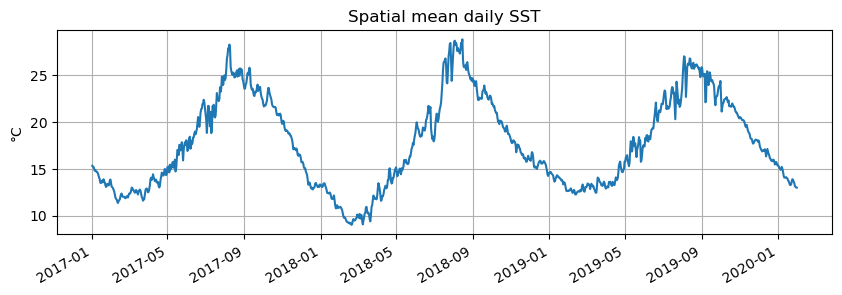

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 이미 이전에 만든 daily 텐서
# tnsr_daily: (nY, nX, nD)
# D: DatetimeIndex 길이 nD
# 없다면 먼저 build_daily_tensor(...) 셀 실행

nY, nX, nD = tnsr_daily.shape
print("tnsr_daily shape:", tnsr_daily.shape)

# 1) 공간 평균 daily SST (NaN 제외)
ref_series = np.nanmean(tnsr_daily, axis=(0, 1))  # shape: (nD,)

# 2) Pandas Series로 변환
ref = pd.Series(ref_series, index=D)
ref.name = "SST_mean"

print(ref.head())
ref.plot(figsize=(10,3))
plt.title("Spatial mean daily SST")
plt.ylabel("°C")
plt.grid(True)
plt.show()


ADF stat (원시계열): -2.5585886711225565
p-value: 0.10186170417505547


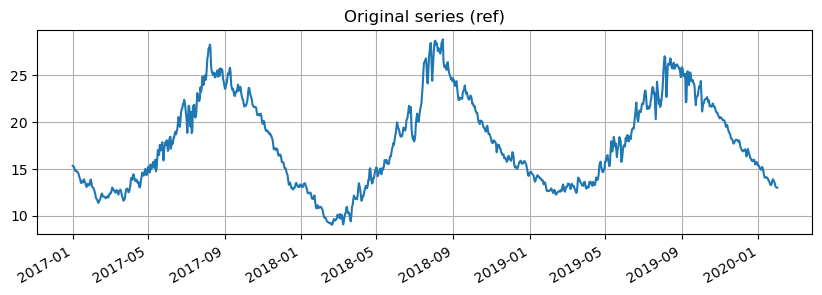

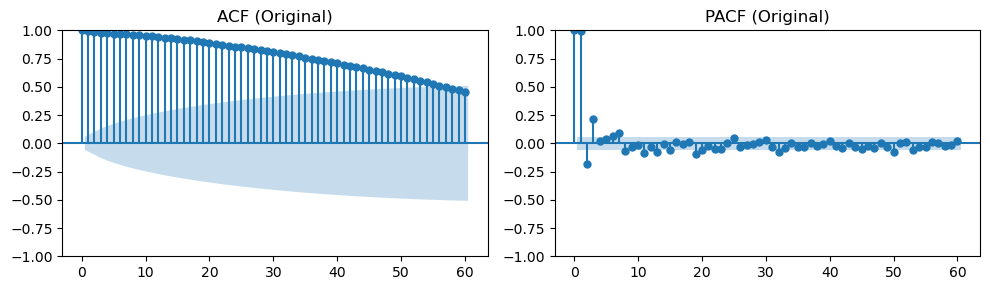

In [16]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 원시계열 ADF (단위근 검정)
res_adf = adfuller(ref.dropna())
print("ADF stat (원시계열):", res_adf[0])
print("p-value:", res_adf[1])

plt.figure(figsize=(10,3))
ref.plot()
plt.title("Original series (ref)")
plt.grid(True)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10,3))
plot_acf(ref.dropna(), lags=60, ax=axes[0])
axes[0].set_title("ACF (Original)")
plot_pacf(ref.dropna(), lags=60, ax=axes[1])
axes[1].set_title("PACF (Original)")
plt.tight_layout()
plt.show()


ADF stat (1차 차분): -4.721397806947712
p-value: 7.669949015632137e-05


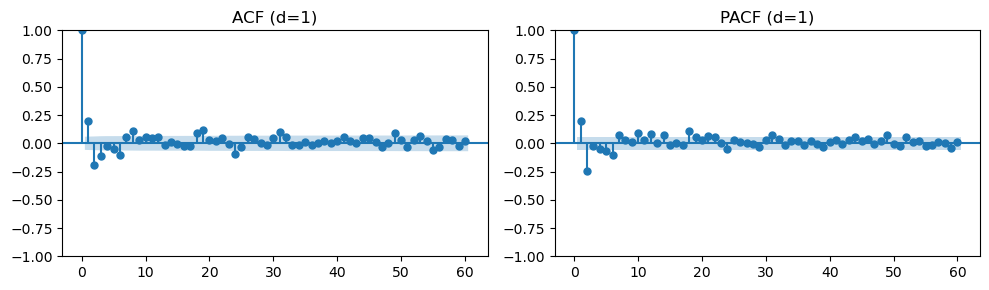

In [17]:
ref_d1 = ref.diff().dropna()

res_adf_d1 = adfuller(ref_d1)
print("ADF stat (1차 차분):", res_adf_d1[0])
print("p-value:", res_adf_d1[1])

fig, axes = plt.subplots(1, 2, figsize=(10,3))
plot_acf(ref_d1, lags=60, ax=axes[0])
axes[0].set_title("ACF (d=1)")
plot_pacf(ref_d1, lags=60, ax=axes[1])
axes[1].set_title("PACF (d=1)")
plt.tight_layout()
plt.show()


In [18]:
from statsmodels.tsa.stattools import acf, pacf

def suggest_arima_order(series, max_p=3, max_q=3, d_max=2, nlags=40):
    """
    한 시계열(series)에 대해 간단히 ARIMA(p,d,q) 추천
    - d: ADF test 기반으로 0..d_max 중 최소
    - p: PACF에서 유의한 lag (1..max_p) 중 가장 큰 것
    - q: ACF 에서 유의한 lag (1..max_q) 중 가장 큰 것
    """
    s = pd.Series(series).dropna()
    
    # --- d 결정 ---
    d = 0
    for dd in range(d_max+1):
        if dd > 0:
            s_d = s.diff(dd).dropna()
        else:
            s_d = s.copy()
        adf_stat, pval, *_ = adfuller(s_d)
        if pval < 0.05:
            d = dd
            s_used = s_d
            print(f"선택된 d={d}, ADF p-value={pval:.4g}")
            break
    else:
        d = d_max
        s_used = s.diff(d).dropna()
        print(f"강제로 d={d_max} 사용 (ADF 유의X)")
    
    # --- ACF/PACF ---
    n = len(s_used)
    lag_acf  = acf(s_used, nlags=nlags, fft=True)
    lag_pacf = pacf(s_used, nlags=nlags, method="ywm")

    # 유의성 기준 (대략 ±1.96/√N)
    thresh = 1.96 / np.sqrt(n)
    
    # p: PACF에서 |pacf(k)| > thresh 인 k (1..max_p) 중 가장 큰 k
    p = 0
    for k in range(1, max_p+1):
        if abs(lag_pacf[k]) > thresh:
            p = k
    # q: ACF에서 |acf(k)| > thresh 인 k (1..max_q) 중 가장 큰 k
    q = 0
    for k in range(1, max_q+1):
        if abs(lag_acf[k]) > thresh:
            q = k
    
    print(f"추천 ARIMA(p,d,q) ≈ ({p},{d},{q})")
    return p, d, q, (lag_acf, lag_pacf, thresh)


In [19]:
p_hat, d_hat, q_hat, _ = suggest_arima_order(ref_series, max_p=3, max_q=3, d_max=2, nlags=40)
print("최종 추천:", (p_hat, d_hat, q_hat))


선택된 d=1, ADF p-value=7.67e-05
추천 ARIMA(p,d,q) ≈ (2,1,3)
최종 추천: (2, 1, 3)


In [20]:
def suggest_sarima_order(
    series,
    m=7,
    max_p=2, max_q=2,
    max_P=1, max_Q=1,
    d_max=2, D_max=1,
    nlags=60
):
    """
    간단 SARIMA 차수 추천:
    - 비계절 d: ADF 기반 0..d_max
    - 계절 D: 0 또는 1 (ADF)
    - 비계절 p,q: ACF/PACF (lag 1..max_p, 1..max_q)
    - 계절 P,Q: ACF/PACF (lag m, 2m.. 중 max_P, max_Q 범위)
    """
    s = pd.Series(series).dropna()

    # --- d 결정 ---
    d = 0
    for dd in range(d_max+1):
        if dd > 0:
            s_d = s.diff(dd).dropna()
        else:
            s_d = s.copy()
        pval = adfuller(s_d)[1]
        if pval < 0.05:
            d = dd
            s_used = s_d
            print(f"[SARIMA] 선택된 d={d}, p-value={pval:.4g}")
            break
    else:
        d = d_max
        s_used = s.diff(d).dropna()
        print(f"[SARIMA] 강제로 d={d_max} 사용")

    # --- D 결정 (0 또는 1) ---
    D = 0
    s_seas_used = s_used.copy()
    pval0 = adfuller(s_seas_used.dropna())[1]
    print(f"[SARIMA] D=0 가정 ADF p-value={pval0:.4g}")

    if D_max >= 1:
        s_seas1 = s_used.diff(m).dropna()
        pval1 = adfuller(s_seas1.dropna())[1]
        print(f"[SARIMA] D=1 가정 ADF p-value={pval1:.4g}")
        if pval1 < pval0:
            D = 1
            s_seas_used = s_seas1
            print(f"[SARIMA] D=1 선택")
        else:
            print(f"[SARIMA] D=0 유지")

    # --- ACF/PACF 계산 ---
    n = len(s_seas_used)
    lag_acf  = acf(s_seas_used, nlags=nlags, fft=True)
    lag_pacf = pacf(s_seas_used, nlags=nlags, method="ywm")
    thresh = 1.96 / np.sqrt(n)

    # 비계절 p,q
    p = 0
    for k in range(1, max_p+1):
        if abs(lag_pacf[k]) > thresh:
            p = k
    q = 0
    for k in range(1, max_q+1):
        if abs(lag_acf[k]) > thresh:
            q = k

    # 계절 P,Q (lag m, 2m, ...)
    P = 0
    Q = 0
    for r in range(1, max_P+1):
        k = r * m
        if k <= nlags and abs(lag_pacf[k]) > thresh:
            P = r
    for r in range(1, max_Q+1):
        k = r * m
        if k <= nlags and abs(lag_acf[k]) > thresh:
            Q = r

    print(f"추천 SARIMA(p,d,q)x(P,D,Q)_m ≈ ({p},{d},{q})x({P},{D},{Q})_{m}")
    return (p, d, q), (P, D, Q)


In [21]:
(p_s, d_s, q_s), (P_s, D_s, Q_s) = suggest_sarima_order(
    ref_series,
    m=7,
    max_p=2, max_q=2,
    max_P=1, max_Q=1,
    d_max=2, D_max=1,
    nlags=60
)
print("최종 추천 SARIMA:", (p_s,d_s,q_s), (P_s,D_s,Q_s,7))


[SARIMA] 선택된 d=1, p-value=7.67e-05
[SARIMA] D=0 가정 ADF p-value=7.67e-05
[SARIMA] D=1 가정 ADF p-value=4.328e-19
[SARIMA] D=1 선택
추천 SARIMA(p,d,q)x(P,D,Q)_m ≈ (2,1,2)x(1,1,1)_7
최종 추천 SARIMA: (2, 1, 2) (1, 1, 1, 7)
